In [1]:
import sys
import os

pwd = os.getcwd()
python_path = pwd[: pwd.rfind("/")]
sys.path.append(python_path)

In [2]:
import torch
import torchvision
import numpy as np
import cv2 as cv
import jupyter_black
import matplotlib.pyplot as plt
from models import WGAN
from constants import WORK_DIR_PATH, ORIGINAL_IMAGES_PATH
from data import FakeBacteriasDataModule
from utils import (
    show_images,
    read_images,
    get_images_grid,
    get_substrates_wgan_checkpoint,
    get_bacterias_wgan_checkpoint,
)

jupyter_black.load()

In [3]:
image = read_images(ORIGINAL_IMAGES_PATH)[0]
image.shape

(890, 1280, 3)

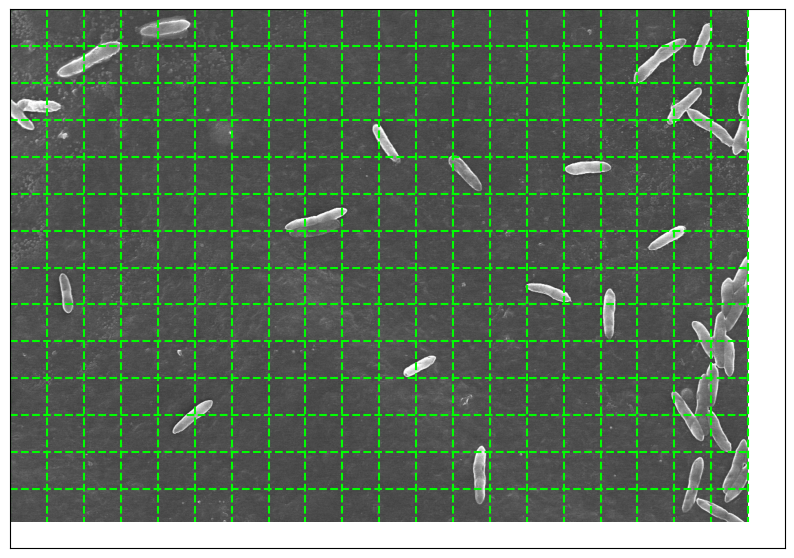

In [4]:
def show_image_with_grid(
    image: np.ndarray, grid_size: int = 32, fig_size: tuple[int, int] = (10, 10)
) -> None:
    plt.figure(figsize=fig_size)
    plt.imshow(image)
    h, w, _ = image.shape
    for i in range(w // grid_size + 1):
        plt.vlines(
            x=grid_size * i, ymin=0, ymax=h, color="#00ff00", linestyles="dashed"
        )
    for i in range(h // grid_size + 1):
        plt.hlines(
            y=grid_size * i, xmin=0, xmax=w, color="#00ff00", linestyles="dashed"
        )
    plt.xticks([])
    plt.yticks([])


show_image_with_grid(image, grid_size=64)

In [5]:
1280 // 64

20

In [9]:
module = FakeBacteriasDataModule()
module.setup("fit")
loader = module.train_dataloader()
for i, batch in enumerate(loader):
    x, y = batch[0]
    show_images(
        [
            (x.reshape((64, 64)), "x"),
            (y.reshape((64, 64)), "y"),
        ]
    )
    print(x.shape)
    break

ValueError: not enough values to unpack (expected 2, got 1)